In [1]:
import json
import os
import pickle
import sys

import torch.nn as nn

from tqdm.notebook import tqdm, trange
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import random, math

from numpy.random import multinomial
from torch.autograd import Variable


from collections import Counter
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)

In [2]:
def get_label_table(path):
    table = dict()
    with open(path, "r") as f:
        for line in f.readlines()[1:]:
            md5, label = line.strip().split(",")
            table[md5] = int(label)
    return table

def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    
def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)
    
def dump_pickle(vector, path):
    with open(path, "wb") as f:
        pickle.dump(vector, f)



In [3]:
label_table = get_label_table("label.csv")

In [4]:
data = [x for x in Path("data/api_sequence_deduplicated").glob("*.pkl")]
len(data)

38198

In [5]:
df = []
for path in tqdm(data):
    md5 = os.path.basename(path)[:-4] +'.vir'
    if md5 in label_table and label_table[md5] == 0:
        vector = read_pickle(path)
        df.append(vector)
len(df)

7926

In [6]:
import itertools

def subsample_frequent_words(corpus, t=10e-5):
    filtered_corpus = []
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus))))
    sum_word_counts = sum(list(word_counts.values()))
    word_counts = {word: word_counts[word]/float(sum_word_counts) for word in word_counts}
    for text in corpus:
        filtered_corpus.append([])
        for word in text:
            # word2vec subsampling formula
            f = word_counts[word]
            if random.random() > ((f - t) / f - math.sqrt(t / f)):
                filtered_corpus[-1].append(word)
    return filtered_corpus

def sample_negative(corpus, sample_size):
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus))))
    word_counts = {word: freq / float(sum(list(word_counts.values()))) for word, freq in word_counts.items()}

    squared_word_counts = {word: freq ** 0.75 for word, freq in word_counts.items()}
    normalizing_factor = sum(list(squared_word_counts.values()))
    sample_probability = {word: freq / normalizing_factor for word, freq in squared_word_counts.items()}
    while True:
        yield [np.random.choice(list(sample_probability.keys()), p=list(sample_probability.values())) for _ in range(sample_size)]



In [27]:
corpus = subsample_frequent_words(df)
vocabulary = set(itertools.chain.from_iterable(corpus))
vocabulary.add("<unk>")
vocabulary.add("<pad>")

word_to_index = {w.lower(): idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w.lower() for (idx, w) in enumerate(vocabulary)}

In [8]:
context_tuple_list = []
w = 4
negative_samples = sample_negative(corpus, sample_size=20)

for text in tqdm(corpus):
    for i, word in enumerate(text):
        first_context_word_index = max(0, i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if i!=j:
                context_tuple_list.append((word, text[j], next(negative_samples)))

print("There are {} pairs of target and context words".format(len(context_tuple_list)))


There are 3349675 pairs of target and context words


In [9]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_percent_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop_training(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(round(100*gain,2)))
        if gain < self.min_percent_gain:
            return True
        else:
            return False

## Batch Mode

In [10]:
def get_batches(context_tuple_list, batch_size=256):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = Variable(torch.from_numpy(np.array(batch_target)).long())
            tensor_context = Variable(torch.from_numpy(np.array(batch_context)).long())
            tensor_negative = Variable(torch.from_numpy(np.array(batch_negative)).long())
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [11]:
class Word2Vec(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings_target = nn.Embedding(vocab_size, embedding_size)
        self.embeddings_context = nn.Embedding(vocab_size, embedding_size)
        
        self.target_linear1 = nn.Linear(embedding_size, embedding_size)
        self.context_linear1 = nn.Linear(embedding_size, embedding_size)

        self.target_linear2 = nn.Linear(embedding_size, 128)
        self.context_linear2 = nn.Linear(embedding_size, 128)

        self.target_linear3 = nn.Linear(128, embedding_size)
        self.context_linear3 = nn.Linear(128, embedding_size)

        

    def forward(self, target_word, context_word, negative_example):
        emb_context = self.embeddings_context(context_word)
        emb_target = self.embeddings_target(target_word)
        
        context_out = F.relu(self.context_linear1(emb_context))
        target_out = F.relu(self.target_linear1(emb_target))
        
        context_out = F.relu(self.context_linear2(context_out))
        target_out = F.relu(self.target_linear2(target_out))

        context_out = F.relu(self.context_linear3(context_out))
        target_out = F.relu(self.target_linear3(target_out))

        emb_product = torch.mul(target_out, context_out)
        emb_product = torch.sum(emb_product, dim=1)
        out = torch.sum(F.logsigmoid(emb_product))
        
        emb_negative = self.embeddings_context(negative_example)
        emb_product = torch.bmm(emb_negative, target_out.unsqueeze(2))
        emb_product = torch.sum(emb_product, dim=1)
        out += torch.sum(F.logsigmoid(-emb_product))

        return -out

In [25]:
import time

vocabulary_size = len(vocabulary)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=100, vocab_size=vocabulary_size)
optimizer = optim.AdamW(net.parameters(),  lr = 0.0001)
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)

n_epochs = 5
epochs = trange(n_epochs, desc="training")
best = {"loss": sys.float_info.max}

net = net.to(device)

total_loss = []
for epoch in epochs:
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=256)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        target_tensor = target_tensor.to(device)
        context_tensor = context_tensor.to(device)
        negative_tensor = negative_tensor.to(device)

        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        iter_loss = loss.item()
        losses.append(iter_loss)
    epoch_loss = np.mean(losses)
    total_loss.append(epoch_loss)
    print("Loss: ", epoch_loss)
    epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
    if epoch_loss < best["loss"]:
        best["state"] = net.state_dict()
        best["loss"] = epoch_loss
        best["epoch"] = epoch + 1


# while True:
#     losses = []
#     context_tuple_batches = get_batches(context_tuple_list, batch_size=2000)
#     for i in tqdm(range(len(context_tuple_batches))):
#         net.zero_grad()
#         target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
#         target_tensor = target_tensor.to(device)
#         context_tensor = context_tensor.to(device)
#         negative_tensor = negative_tensor.to(device)

#         loss = net(target_tensor, context_tensor, negative_tensor)
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#     print("Loss: ", np.mean(losses))
#     early_stopping.update_loss(np.mean(losses))
#     if early_stopping.stop_training():
#         break

cuda


Loss:  1.4402685101317445
Loss:  6.15789612921419e-05
Loss:  1.581422911691486e-07
Loss:  7.197196957544627e-10
Loss:  8.199338878641142e-11



([<matplotlib.axis.XTick at 0x2212b9e3a88>,
 <a list of 5 Text xticklabel objects>)

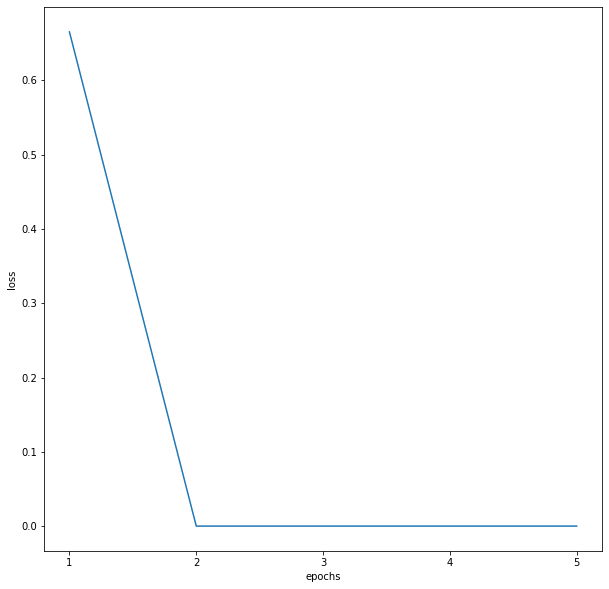

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.arange(n_epochs)
plt.figure(figsize=(10, 10))
plt.plot(index, total_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xticks(index, [i for i in range(1, n_epochs+1)])

In [14]:
from sklearn.manifold import TSNE

%config InlineBackend.figure_format = 'retina'

embeddings = net.embeddings_context.weight.to('cpu').data.numpy()
embed_tsne = TSNE(perplexity=40, n_components=2, init='pca', random_state=41, n_jobs=-1).fit_transform(embeddings)


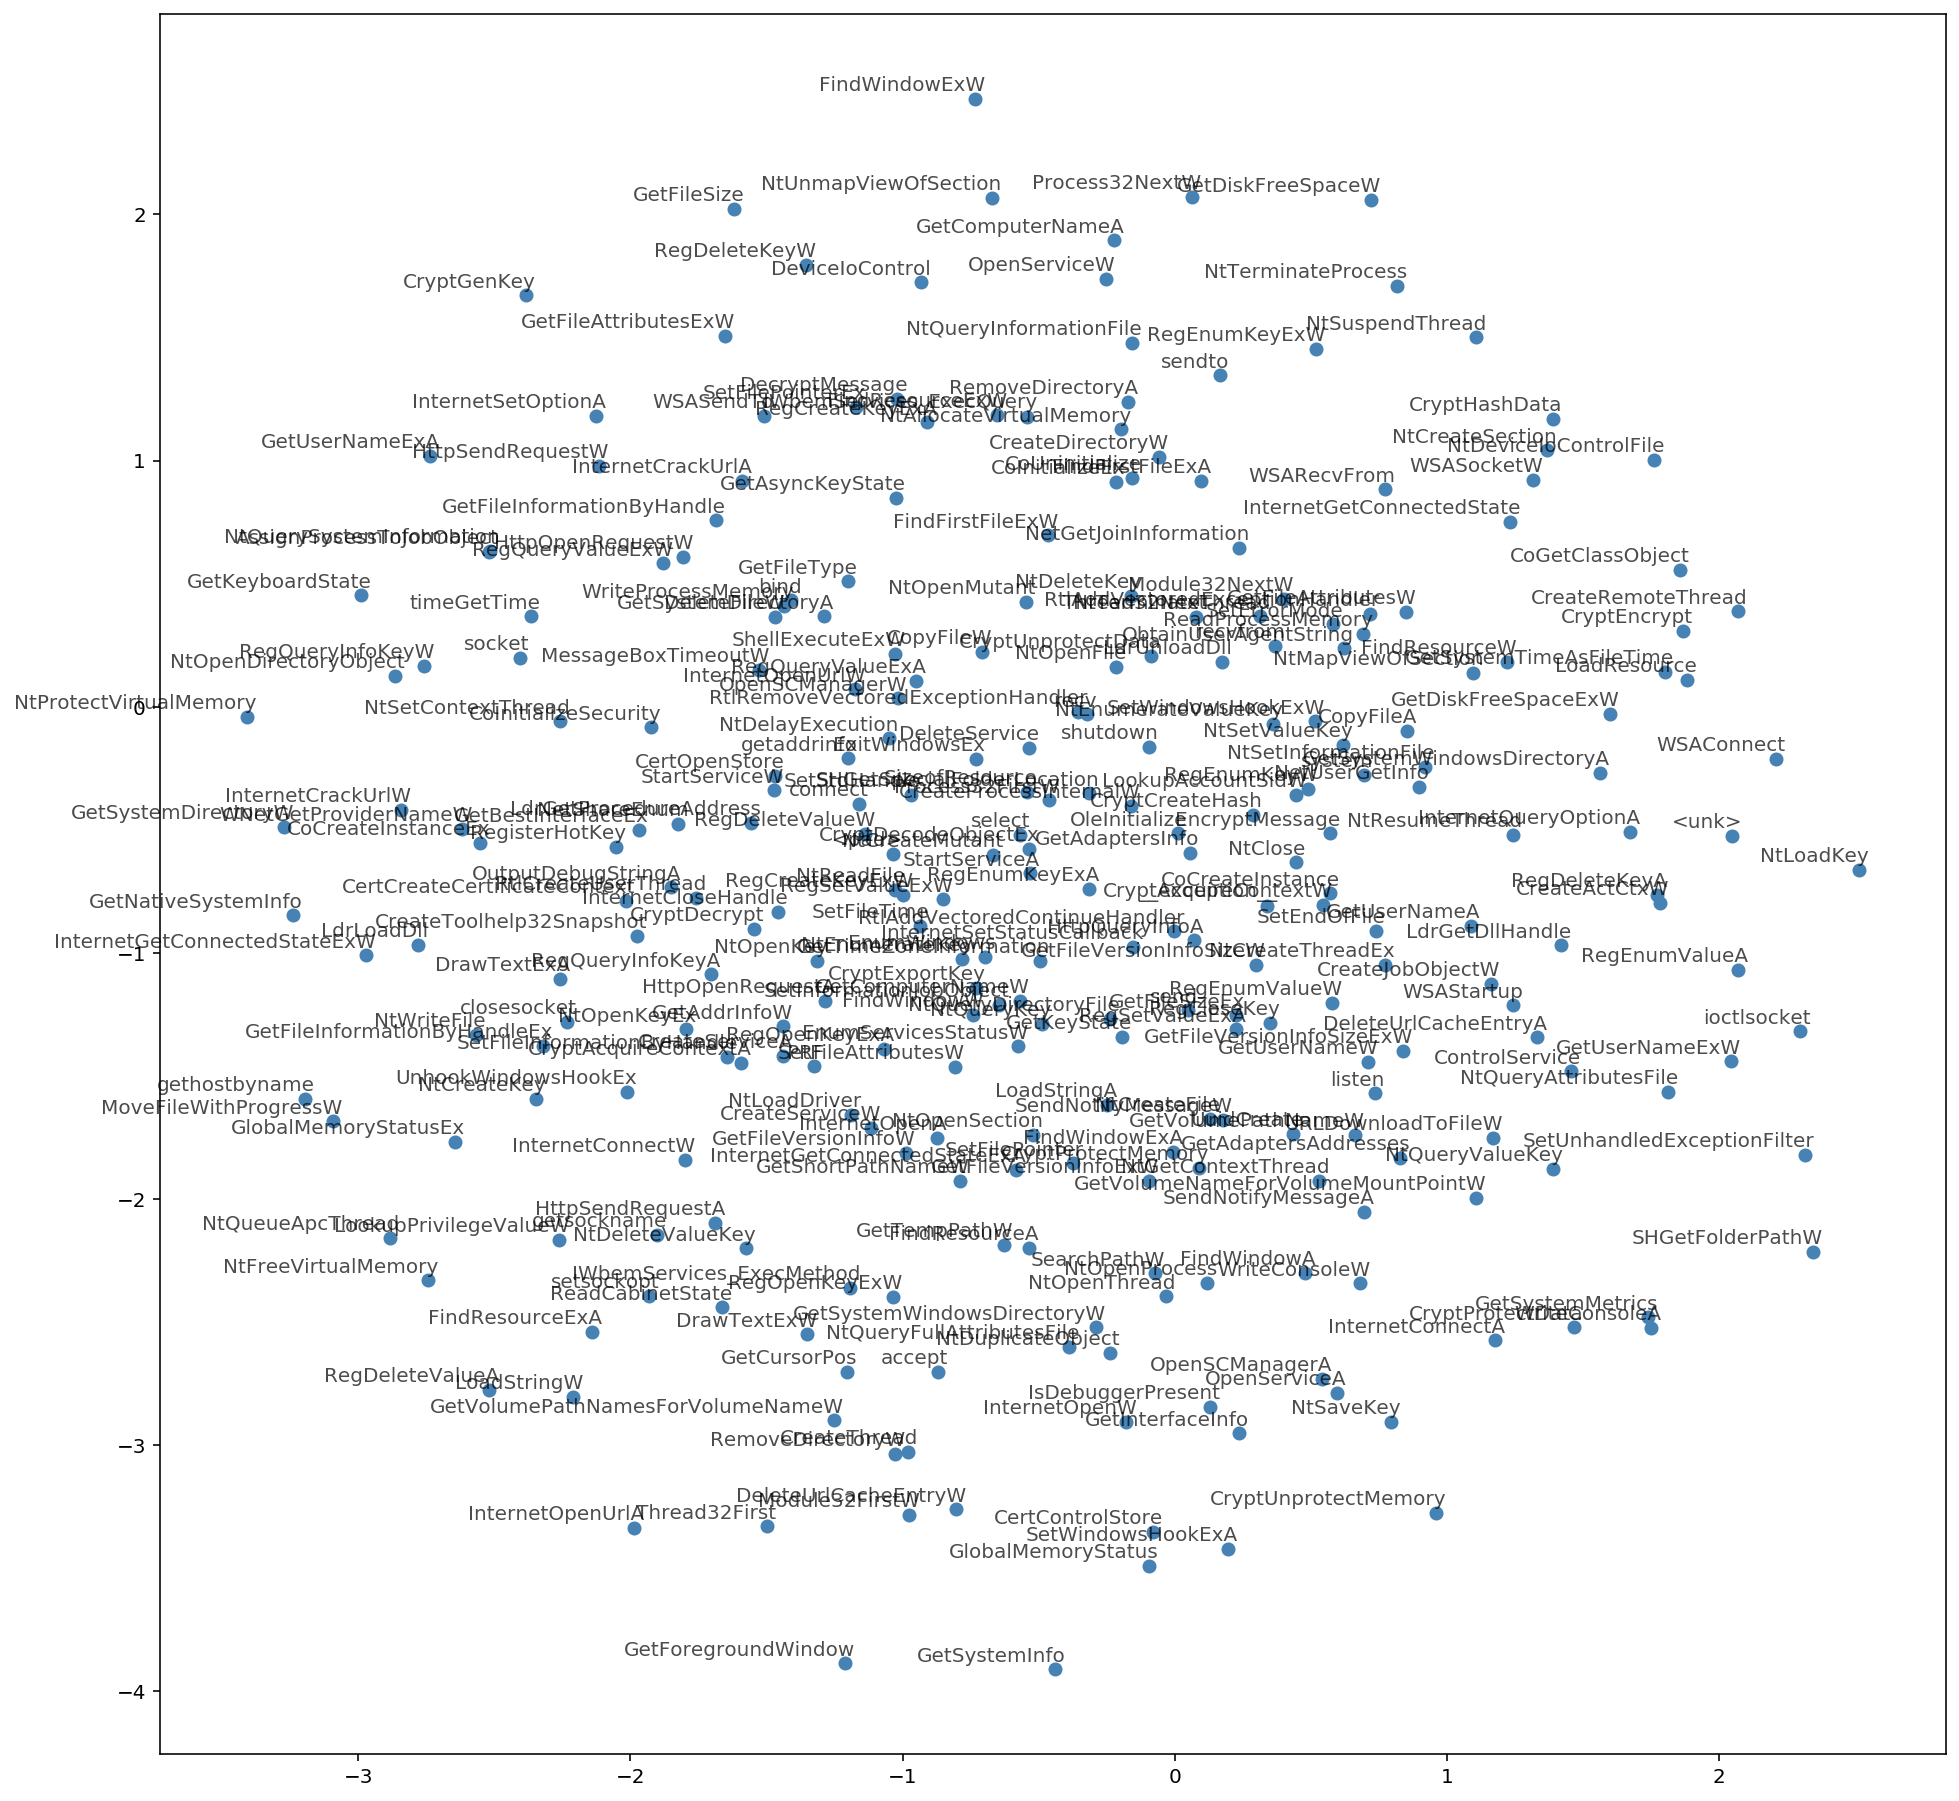

In [15]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(len(embeddings)):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(index_to_word[idx], xy=(embed_tsne[idx, 0], embed_tsne[idx, 1]), xytext=(5,2), alpha=0.7, textcoords='offset points',
                     ha='right',
                     va='bottom')
fig.savefig("apicall_embedded")

In [28]:
import pickle

def save_pkl(data, path):
    with open(path, "wb") as f:
        pickle.dump(data, f)

torch.save(net.embeddings_context.weight.cpu().detach().numpy(), "Pretrained_Apicall_Vector_100.pkl")
save_pkl(word_to_index, "word_to_index.pkl")
save_pkl(index_to_word, "index_to_word.pkl")
